In [120]:
## @Author Suganth Kumar , Kireet Bharadwaj and Manish DM

# Allstate Purchase Prediction Challenge
#Problem Statement - The All State Insurance dataset is about the customer interaction history, information regarding
#                    quoted policy and cost regarding the various coverage options for a car insurance plan. 
#                    Using a customer’s shopping history, to predict what policy they will end up choosing?
#                    The goal of this project is to predict exact combination of coverage options(A through G)
#                    the customer would choose while purchasing the plan – It is a Multinomial Classification Problem.

#Dataset Source - https://www.kaggle.com/c/allstate-purchase-prediction-challenge/data
#References for approach - https://www.youtube.com/watch?v=HGr1yQV3Um0
#                          http://worldconferences.net/proceedings/aics2014/PAPER%20AICS/A049%20-%20PREDICTING%20PURCHASED%20POLICY%20-%20SABA%20ARSLAN.pdf

In [121]:
##Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']= 9,7

# Loading the dataset

In [122]:
# read in the dataset
df_train = pd.read_csv("E:/DSP Course/DSP-Project1/All-State-Train.csv")

In [123]:
#Plan chosen based on concatenation of all the variables data
df_train['plan'] = df_train["A"].map(str)+df_train['B'].map(str)+df_train['C'].map(str)+df_train['D'].map(str)+df_train['E'].map(str)+df_train['F'].map(str)+df_train['G'].map(str)

# Data Wrangling and Feature Engineering

In [124]:
df_train['HourofDay'] = df_train['time'].apply(lambda x: x.split(':')[0]).astype('int64')
df_train['TimeofDay'] = df_train['HourofDay'].apply(lambda x : 'Morning' if(x in range(6,16)) else ( 'Evening' if(x in range(16,20)) else 'Night'))
df_train['weekend'] = df_train['day'].apply(lambda x:'Yes' if x<5 else 'No' )
df_train['agediff'] = df_train['age_oldest'] - df_train['age_youngest']
df_train['Young-Group'] = df_train['age_youngest']*df_train['group_size']

In [125]:
df_train.loc[(df_train['agediff']==0)&(df_train['group_size']),'Individual'] = 'Yes'
df_train.Individual.fillna('No',inplace=True)

In [126]:
#Fix the missing values for duration_previous and C_previous

df_train.duration_previous.fillna(0,inplace=True)
df_train.C_previous.fillna(0,inplace=True)

In [127]:
#Fixing the missing values for car_value
df_train['car_value'].fillna(method='bfill',inplace=True)

In [128]:
#Fixing the missing values in the column risk
# We are going to fill the missing values in column risk by building a regression model
df_train_datanorisk = df_train.loc[df_train['risk_factor'].isnull(),]
df_train_datarisk = df_train.loc[df_train['risk_factor'].notnull(),]


lm = LinearRegression()
lm.fit(df_train_datarisk[['married_couple','homeowner','Young-Group']],df_train_datarisk['risk_factor'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [129]:
pred = lm.predict(df_train_datanorisk[['married_couple','homeowner','Young-Group']])
pred = pred.round()

In [130]:
df_train_datanorisk['risk_factor'] = pd.Series(pred,index=df_train_datanorisk.index)

In [131]:
df_train.loc[df_train['risk_factor'].isnull(),'risk_factor'] = df_train_datanorisk['risk_factor'] 

# Data Preprocess

In [132]:
# trainsub is subset of train that only includes purchases
df_trainpur = df_train.loc[df_train['record_type']==1,]

In [133]:
# trainex is subset of train that excludes purchases
df_trainex = df_train.loc[df_train.duplicated('customer_ID',keep='last'), :]

In [134]:
# trainex2 only includes last quote before purchase
df_trainex2 = df_trainex.drop_duplicates(subset='customer_ID',keep='last')

In [135]:
#Setting customerId as Index
df_trainpur.set_index('customer_ID',inplace=True)
df_trainex2.set_index('customer_ID',inplace=True)

In [136]:
df_trainpur['changed'] = df_trainpur['plan']==df_trainex2['plan']

In [137]:
df_trainpur['changed'] = df_trainpur['changed'].apply(lambda x:0 if x==True else 1)

In [138]:
df_trainex2['quotesCount'] = df_trainex.groupby('customer_ID')['plan'].count()
df_trainex2['PlanUniqueCount'] = df_trainex.groupby('customer_ID')['plan'].nunique()

In [139]:
## Creating a customer stability column to see how often customers tend to change

In [140]:
df_trainex2['stability'] = ((df_trainex2['quotesCount']-df_trainex2['PlanUniqueCount']+1)/df_trainex2['quotesCount'])

In [141]:
### Below dataframe contains the last quote for products and also the purchasequote of the products.
d = {'A':'A_p','B':'B_p','C':'C_p','D':'D_p','E':'E_p','F':'F_p','G':'G_p','plan':'plan_p'}
df_trainex3 = pd.concat((df_trainex2, df_trainpur[['A','B','C','D','E','F','G','plan']].rename(columns=d)),axis=1)
df_trainex3.head()

,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,car_value,...,PlanUniqueCount,stability,A_p,B_p,C_p,D_p,E_p,F_p,G_p,plan_p
customer_ID,,,,,,,,,,,,,,,,,,,,,
10000000,8,0,0,12:03,IN,10001,2,0,2,g,...,2,0.875000,1,0,2,2,1,2,1,1022121
10000005,5,0,3,08:58,NY,10006,1,0,10,e,...,2,0.800000,0,0,3,2,0,0,2,0032002
10000007,7,0,4,08:43,PA,10008,1,0,11,c,...,4,0.571429,0,0,1,2,0,0,1,0012001
10000013,3,0,2,16:36,WV,10014,2,1,3,d,...,2,0.666667,1,1,3,2,1,1,3,1132113
10000014,5,0,4,16:43,MO,10015,1,0,5,d,...,3,0.600000,1,1,1,1,0,2,2,1111022


# Data Exploration

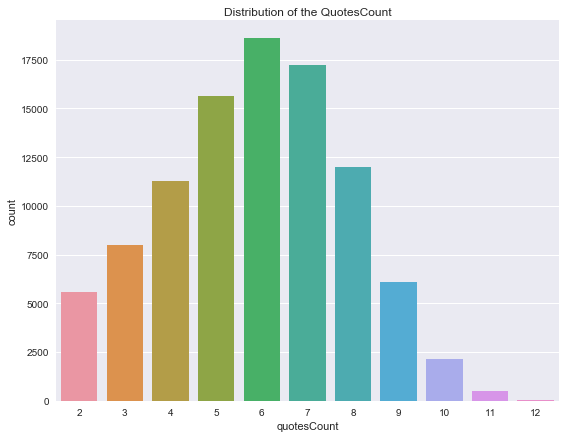

In [142]:
# A distribution of the number of quotes of the customers.
# We can see that most of the customers  5 to 7 quotes before making a purchase
sns.countplot(df_trainex2['quotesCount'])
plt.title("Distribution of the QuotesCount")

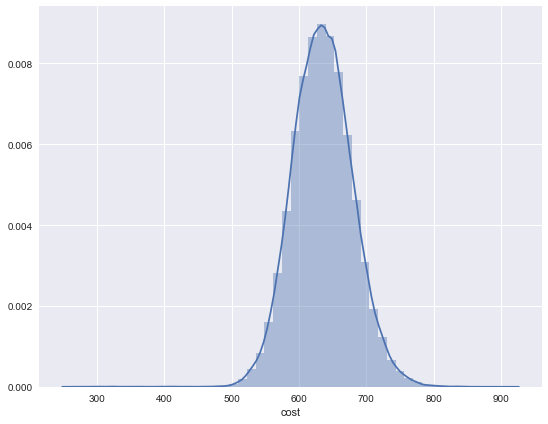

In [143]:
#Distribution of cost
#Most of the customers are spending in the range of $600 to $650
sns.distplot(df_trainex2.cost)

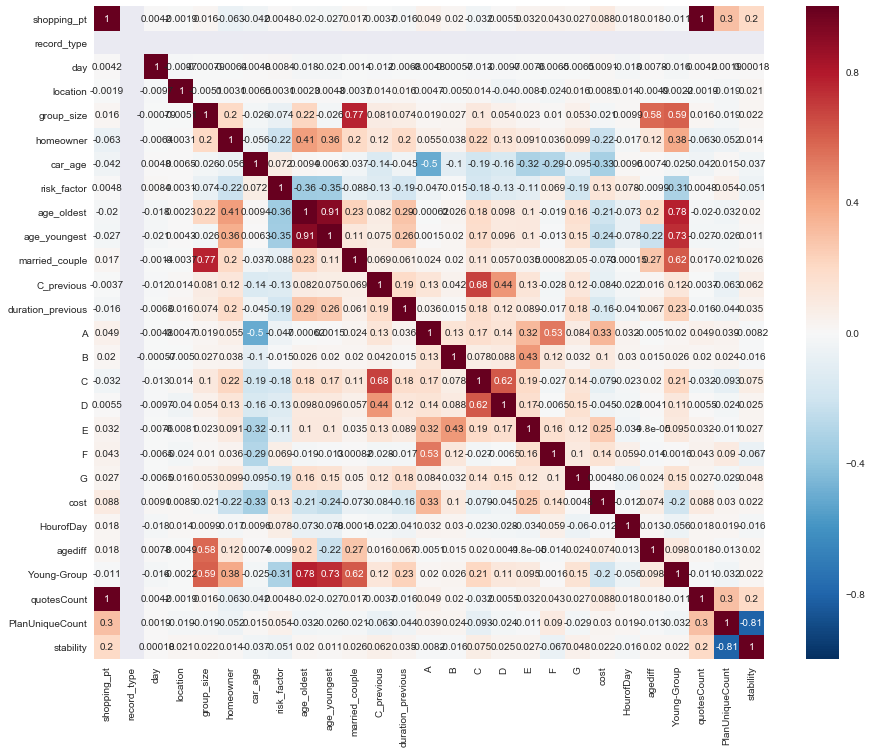

In [144]:
plt.figure(figsize=(15,12))
sns.heatmap(df_trainex2.corr(),annot=True)

In [145]:
a = 1-(df_trainpur.groupby('shopping_pt')['changed'].sum()/df_trainpur.groupby('shopping_pt')['changed'].count())

(1, 14)

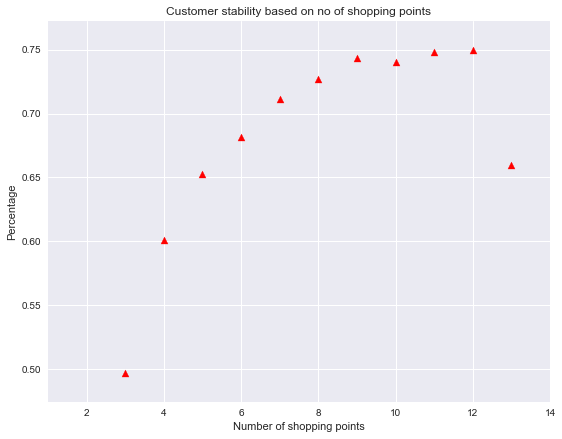

In [146]:
#This is a scatter plot to show if the customer would stick to his last viewed quote
plt.scatter(a.index,a,marker='^',color='red')
plt.title("Customer stability based on no of shopping points")
plt.xlabel("Number of shopping points")
plt.ylabel("Percentage")
plt.xlim(1,14)

In [147]:
b = df_trainpur.groupby('HourofDay')['changed'].sum()/df_trainpur.groupby('HourofDay')['changed'].count()

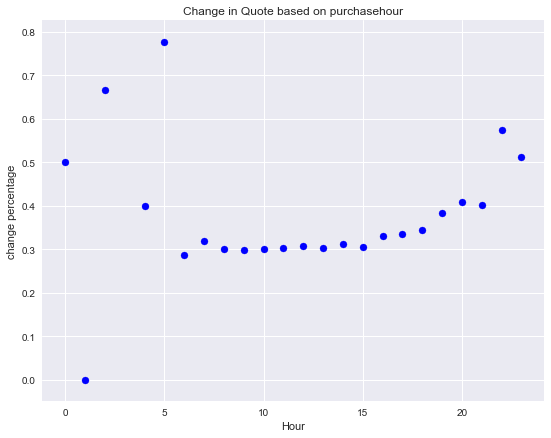

In [148]:
#Below plot shows some insights on the purchase hour where there is a likelihood of change in the quote
plt.scatter(b.index,b,color='blue')
plt.title("Change in Quote based on purchasehour")
plt.xlabel("Hour")
plt.ylabel("change percentage")

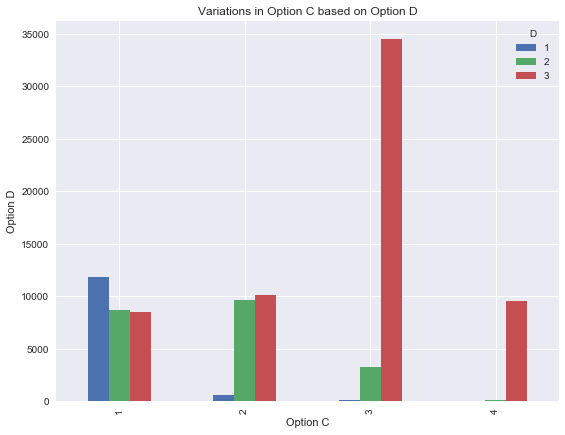

In [149]:
#Below plot shows 
pd.crosstab(df_trainpur['C'],df_trainpur['D']).plot(kind='bar')
plt.title("Variations in Option C based on Option D")
plt.xlabel('Option C')
plt.ylabel('Option D')

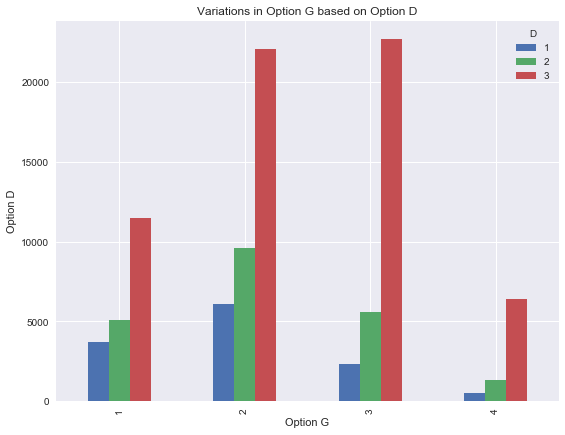

In [150]:
#Below plot shows 
pd.crosstab(df_trainpur['G'],df_trainpur['D']).plot(kind='bar')
plt.title("Variations in Option G based on Option D")
plt.xlabel('Option G')
plt.ylabel('Option D')

# Base Model

In [151]:
### Base model - Take the last quote as the prediction
df_trainex3.loc[(df_trainex3['plan']==df_trainex3['plan_p']),'plan_compare'] = 1
df_trainex3.plan_compare.fillna(0,inplace=True)

In [154]:
#Calculating the Accuracy of Base model
base_accuracy  = df_trainex3['plan_compare'].sum()/len(df_trainex3['plan_compare'])
print("Accuracy_of_Base_Model",base_accuracy)

Accuracy_of_Base_Model 0.6878949375831108


In [155]:
## To Build up on the base model creating columns comparing purchase quote and last quote options
df_trainex3.loc[(df_trainex3['A']==df_trainex3['A_p']),'A_compare'] = 1
df_trainex3.A_compare.fillna(0,inplace=True)

df_trainex3.loc[(df_trainex3['B']==df_trainex3['B_p']),'B_compare'] = 1
df_trainex3.B_compare.fillna(0,inplace=True)


df_trainex3.loc[(df_trainex3['C']==df_trainex3['C_p']),'C_compare'] = 1
df_trainex3.C_compare.fillna(0,inplace=True)


df_trainex3.loc[(df_trainex3['D']==df_trainex3['D_p']),'D_compare'] = 1
df_trainex3.D_compare.fillna(0,inplace=True)

df_trainex3.loc[(df_trainex3['E']==df_trainex3['E_p']),'E_compare'] = 1
df_trainex3.E_compare.fillna(0,inplace=True)

df_trainex3.loc[(df_trainex3['F']==df_trainex3['F_p']),'F_compare'] = 1
df_trainex3.F_compare.fillna(0,inplace=True)


df_trainex3.loc[(df_trainex3['G']==df_trainex3['G_p']),'G_compare'] = 1
df_trainex3.G_compare.fillna(0,inplace=True)



In [156]:
print(len(df_trainex3.loc[(df_trainex3['A_compare']==0) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==0) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==0) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==0) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==0)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==0) & (df_trainex3['G_compare']==1)]))

print(len(df_trainex3.loc[(df_trainex3['A_compare']==1) & (df_trainex3['B_compare']==1) & (df_trainex3['C_compare']==1) & (df_trainex3['D_compare']==1) & (df_trainex3['E_compare']==1)
               & (df_trainex3['F_compare']==1) & (df_trainex3['G_compare']==0)]))


1404
1980
2041
1136
1473
1503
7848


# Model to predict customers who will change their quotes

In [157]:
input_features = df_trainex3.columns.drop('plan_compare')
X = df_trainex3[input_features]
y = df_trainex3['plan_compare']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [159]:
X.columns

Index(['shopping_pt', 'record_type', 'day', 'time', 'state', 'location',
       'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor',
       'age_oldest', 'age_youngest', 'married_couple', 'C_previous',
       'duration_previous', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'cost', 'plan',
       'HourofDay', 'TimeofDay', 'weekend', 'agediff', 'Young-Group',
       'Individual', 'quotesCount', 'PlanUniqueCount', 'stability', 'A_p',
       'B_p', 'C_p', 'D_p', 'E_p', 'F_p', 'G_p', 'plan_p', 'A_compare',
       'B_compare', 'C_compare', 'D_compare', 'E_compare', 'F_compare',
       'G_compare'],
      dtype='object')

In [160]:
features = ['state','cost','age_oldest','age_youngest','car_age','car_value','risk_factor','shopping_pt','TimeofDay','group_size','homeowner',
            'married_couple','duration_previous','C_previous','stability','quotesCount','A','B','C','D','E','F','G']

In [161]:
X_train['C_previous'].value_counts()

3.0    28049
1.0    17550
2.0    11324
4.0     9744
0.0     1239
Name: C_previous, dtype: int64

In [162]:
#Label Encoder to encode all the categorical variables
for columns in X_train[features].columns:
    if(X_train[columns].dtype == 'O'):
        encode = LabelEncoder()
        encode.fit(X_train[columns].values)
        X_train.loc[:,columns]=encode.transform(X_train[columns].values)

In [163]:
## Random Forest Model to predict plan_compare( Which denotes customers who are likely to change)
rf = RandomForestClassifier()
rf.fit(X_train[features],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
for columns in X_test[features].columns:
    if(X_test[columns].dtype == 'O'):
        encode = LabelEncoder()
        encode.fit(X_test[columns].values)
        X_test.loc[:,columns]=encode.transform(X_test[columns].values)

In [165]:
pred = rf.predict(X_test[features])

# Building model to improve base accuracy

In [166]:
##Based on our analysis we find that if we improve the prediction of option G alone It will improve the base model as whole
input_features = df_trainex3.columns.drop('G_p')

In [167]:
features = ['state','cost','age_oldest','age_youngest','car_age','shopping_pt','TimeofDay','group_size','homeowner',
            'married_couple','C_previous','stability','quotesCount','A','B','C','D','E','F','G','plan_compare']

In [168]:
X1_train = df_trainex3.loc[X_train.index,input_features]

In [169]:
X1_test = df_trainex3.loc[X_test.index,input_features]

In [170]:
X1_test['plan_compare'] = pd.Series(pred,index=X1_test.plan_compare.index)

In [171]:
y_train = X.loc[X_train.index,'G_p']

In [172]:
y_test = df_trainex3.loc[X1_test.index,'G_p']

In [173]:
#Label encoder to encode the categorical columns
for columns in X1_train[features].columns:
    if(X1_train[columns].dtype == 'O'):
        encode = LabelEncoder()
        encode.fit(X1_train[columns].values)
        X1_train.loc[:,columns]=encode.transform(X1_train[columns].values)

In [174]:
##Building a RandomForest Classifier to predict G
rf = RandomForestClassifier()
rf.fit(X1_train[features],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
for columns in X1_test[features].columns:
    if(X1_test[columns].dtype == 'O'):
        encode = LabelEncoder()
        encode.fit(X1_test[columns].values)
        X1_test.loc[:,columns]=encode.transform(X1_test[columns].values)

In [176]:
#Predicting the option G for Test dataset
pred_g = rf.predict(X1_test[features])

In [177]:
confusion_matrix(y_test,pred_g)

array([[4822, 1116,  156,   37],
       [1087, 9693,  356,  102],
       [ 304,  723, 8027,  214],
       [  83,  240,  478, 1665]], dtype=int64)

In [178]:
Accu_base_concept =X1_test['plan_compare'].sum()/len(X1_test['plan_compare'])

In [179]:
X1_test['pred_g'] = pd.Series(pred_g,index=X1_test.index)

In [180]:
X1_test['plan_after_g'] = X1_test["A"].map(str)+X1_test['B'].map(str)+X1_test['C'].map(str)+X1_test['D'].map(str)+X1_test['E'].map(str)+X1_test['F'].map(str)+X1_test['pred_g'].map(str)

In [181]:
X1_test.loc[(X1_test['plan_after_g']==X1_test['plan_p']),'plan_compare_new'] = 1
X1_test.plan_compare_new.fillna(0,inplace=True)

In [182]:
Acc_changed = X1_test[X1_test['plan_compare']==0]['plan_compare_new'].sum()/len(X1_test['plan_compare'])

In [183]:
print("Accuracy of base model on test data",Accu_base_concept)
print("Accuracy of final model on test data",(Accu_base_concept+Acc_changed))

Accuracy of base model on test data 0.7553516819571865
Accuracy of final model on test data 0.8702539257121258
